<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/MARLMOT/MARLMOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MARLMOT**

This notebook contains a basic MARLMOT implementation. The base tracker will be SORT and Multi-Agent Policy Parameterized by a Neural Network will be used to manage each track.

The Policy will be trained on the MOT 2015 challenge

In [1]:
!wget https://motchallenge.net/data/MOT15.zip

zsh:1: command not found: wget


In [2]:

!jar xf MOT15.zip

The operation couldn’t be completed. Unable to locate a Java Runtime that supports jar.
Please visit http://www.java.com for information on installing Java.



In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

In [29]:
TRAIN_FOLDERS = r"/Users/fpfp2/Desktop/Masters Thesis/ParticleTracking/RodTracker/src/RodTracker/resources/example_data/csv"
# TRAIN_FOLDERS
# TRAIN_NAMES = next(iter(os.walk(TRAIN_FOLDERS)))[1]
# TRAIN_NAMES = next(iter(os.walk(TRAIN_FOLDERS)))[1]
TRAIN_NAMES = next(os.walk(TRAIN_FOLDERS))[1]
TRAIN_NAMES

[]

In [54]:
GT_COLS = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height"] #what are these?? -bounding box

bb_left - min of either x1cam1 x2cam1 
bb_top - min or max (check) y1cam1 y2cam1
bb_width - abs(x1cam1 - x2cam1)
bb_height - abs(y1cam1 - y2cam1)
frame - frame 
id - particle 

cam1 = gp3
cam2 = gp4

starts at column 11
frame = 19
particle = 22
x1_cam1 = 11
y1_cam1 = 12

In [55]:
# train_folder = os.path.join(TRAIN_FOLDERS, TRAIN_NAMES[0])
train_folder = "/Users/fpfp2/Desktop/Masters Thesis/ParticleTracking/RodTracker/src/RodTracker/resources/example_data/csv/"

# gt = pd.read_csv(os.path.join(train_folder, "gt/gt.txt"), usecols=[0,1,2,3,4,5], header=None)

bb_left = min()
gt = pd.read_csv(os.path.join(train_folder, "rods_df_black.csv"), usecols=[19,22,11,,4,5], header=None) # col 11-18
gt.columns = GT_COLS
gt.head()

,frame,id,bb_left,bb_top,bb_width,bb_height
0,x1,y1,z1,x2,y2,l
1,-5.289254138526361,3.56316044584448,4.21387480172928,-4.928108868047801,4.08086179001456,0.8746074704483902
2,-5.5222997639735905,0.1051861611653,-0.19578375333392903,-4.67365987995805,0.373974344856271,0.9060288840820769
3,-4.93218799163194,-0.4172582728568441,-0.42758018963717703,-4.60477325651948,-1.27707198424272,0.9242917714607721
4,-4.43031316726678,2.7714904627359602,1.7838104896244897,-3.5992936757413703,2.4340690134744203,0.9389335781363721


In [56]:
def get_color(idx):
    """ Converts an index to a color
        """
    blue = idx*30 % 256
    green = idx*103 % 256
    red = idx*50 % 256
    return (red, green, blue)
  

In [75]:
training_folder = "/Users/fpfp2/Desktop/Masters Thesis/ParticleTracking/RodTracker/src/RodTracker/resources/example_data/images/gp3/0500.jpg"
train_images = sorted(glob(os.path.join(training_folder, "**/*.jpg")))

# get current frame
idx = 0
current_tracks = gt.loc[gt.frame == (idx + 1), :]
frame = cv2.cvtColor(cv2.imread(train_images[idx]), cv2.COLOR_BGR2RGB)

# draw ground truth on frame
for id in current_tracks.id:
    track = current_tracks[current_tracks.id == id]

    color = get_color(id)

    pt1 = track.iloc[0, 2:4].to_numpy().astype(int)
    pt2 = pt1 + track.iloc[0, 4:6].to_numpy().round().astype(int)
    frame = cv2.rectangle(frame, pt1, pt2, color, 2)


# display frame
plt.imshow(frame)



[]


IndexError: list index out of range

###Get YOLOv8

In [62]:
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
!pip install -r requirements.txt

fatal: destination path 'ultralytics' already exists and is not an empty directory.
/Users/fpfp2/Desktop/Masters Thesis/CV_tracking/MARLMOT/ultralytics


/Users/fpfp2/opt/anaconda3/envs/RodTracker/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [63]:
%cd ..
!pip install ultralytics

/Users/fpfp2/Desktop/Masters Thesis/CV_tracking/MARLMOT


In [64]:
!pip install filterpy

import SORT

In [65]:
!wget https://raw.githubusercontent.com/itberrios/CV_tracking/main/SORT/sort.py
# !wget https://raw.githubusercontent.com/abewley/sort/master/sort.py # OG SORT
from sort import *

zsh:1: command not found: wget


Import YOLO model and define detection function

In [66]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

In [67]:
def get_detections(model, frame, conf=0.25):
    """ Obtains object detections from a single frame
        Inputs:
            model - YOLOv8 model object
            frame - RGB frame for detection
        Outputs:
            detections - array containing all detections and classes
                [[x1,y1,x2,y2,cls],...]
        NOTE: can modify this to obtain detections for batches of frames
        """
    # can also process multiple frames at once
    results = model(source=frame, stream=True, conf=conf, nms=True, 
                    iou=0.5, verbose=False)

    for result in results:
        xyxy = result.boxes.xyxy.cpu().numpy()
        cls = result.boxes.cls.cpu().numpy()
        conf_score = result.boxes.conf.cpu().numpy()

    return np.hstack((xyxy, np.c_[cls], np.c_[conf_score]))

     


Get MSCOCO classes

In [68]:
!ls

ADL-Rundle-6_SORT_tracks.csv       interactive_train_eval.ipynb
ADL-Rundle-6_YOLOv8_detections.csv network.py
MARLMOT.ipynb                      ppo.py
MOT15                              sort.py
README.md                          test_world.py
RodTracker_MARLMOT.ipynb           track_utils.py
__pycache__                        train.py
dataloader.py                      train_world.py
eval.py                            trained_models
inference.py                       ultralytics
interactive_model_eval.ipynb       yolov8n.pt


In [69]:

import yaml

coco_fp = r"ultralytics/ultralytics/cfg/datasets/coco.yaml"
with open(coco_fp, "r") as stream:
    try:
        coco_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# get classes dictionary
classes = coco_info['names']

Run tracker on frames

In [70]:
tracker = Sort(max_age=3, min_hits=1, iou_threshold=0.3)


result_frames = []
all_detections = []
all_tracks = []
for fpath in train_images:
    frame = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
    detections = get_detections(model, frame)

    # don't send confidence to the tracker
    current_tracks = tracker.update(detections[:, :5].astype(int))
    all_detections.append(detections)
    all_tracks.append(current_tracks)

    # draw track info on frames
    for trk in current_tracks:
        pt1 = trk[0:2].astype(int)
        pt2 = trk[2:4].astype(int)

        # get color from track id (it looks better this way)
        color = get_color(trk[4])
        # class and track id
        label = str(classes[int(trk[5])] + '_' + str(int(trk[4])))

        frame = cv2.rectangle(frame, pt1, pt2, color, 2)
        frame = cv2.putText(frame, label, (pt1 + 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, 
                            color, thickness=2)

    # save results
    result_frames.append(frame)

In [71]:
detections = get_detections(model, frame)
detections

NameError: name 'frame' is not defined

In [22]:
all_tracks[0]

array([[        541,         216,         554,         248,           7,           0],
       [        211,         201,         226,         255,           6,           0],
       [        269,         210,         284,         246,           5,           0],
       [        587,         211,         602,         246,           4,           0],
       [        455,         208,         483,         274,           3,           0],
       [        224,         185,         256,         282,           2,           0],
       [        293,         150,         351,         321,           1,           0]])

In [23]:
frame_tracks = all_tracks[100] 
frame_tracks = np.round(frame_tracks[frame_tracks[:,-1] == 0][:, :4]).astype(int) # only get bboxes of person tracks
frame_tracks


array([[418, 198, 443, 286],
       [546, 160, 621, 377],
       [302, 218, 318, 267],
       [397, 200, 422, 285],
       [439, 139, 537, 382],
       [256, 206, 278, 278],
       [286, 220, 300, 262],
       [319, 220, 336, 268],
       [229, 206, 250, 271]])

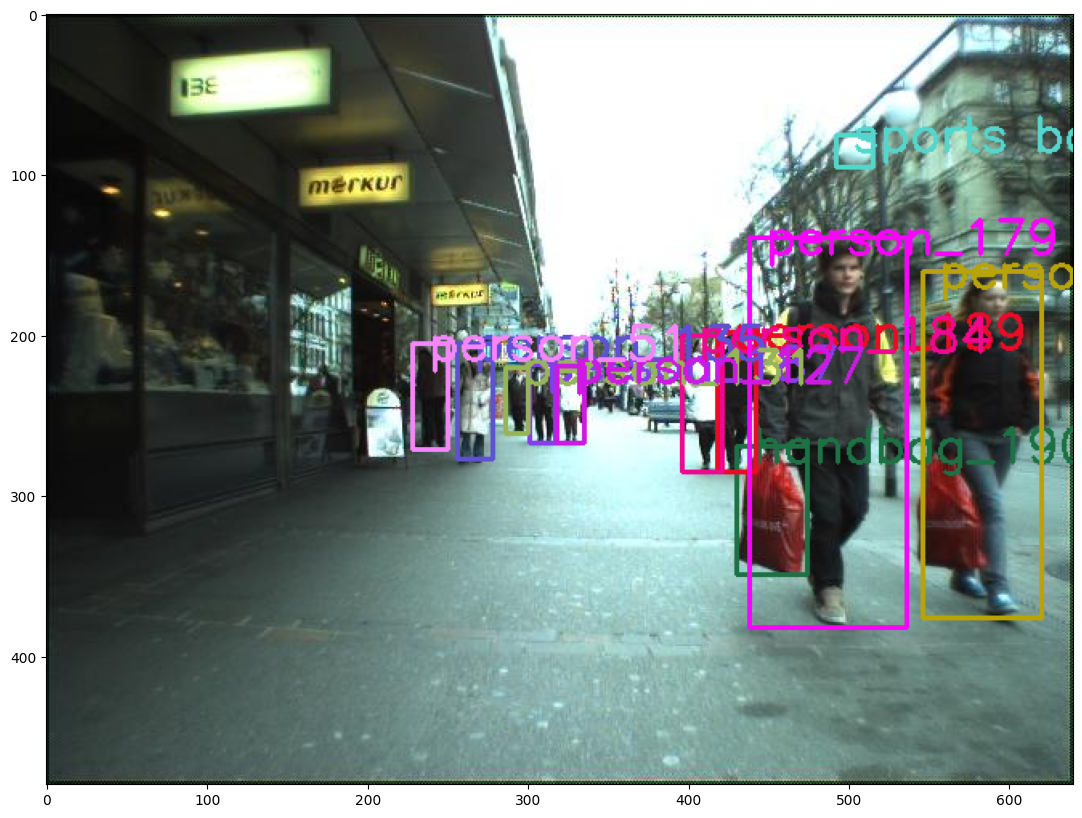

In [24]:
plt.imshow(result_frames[100])

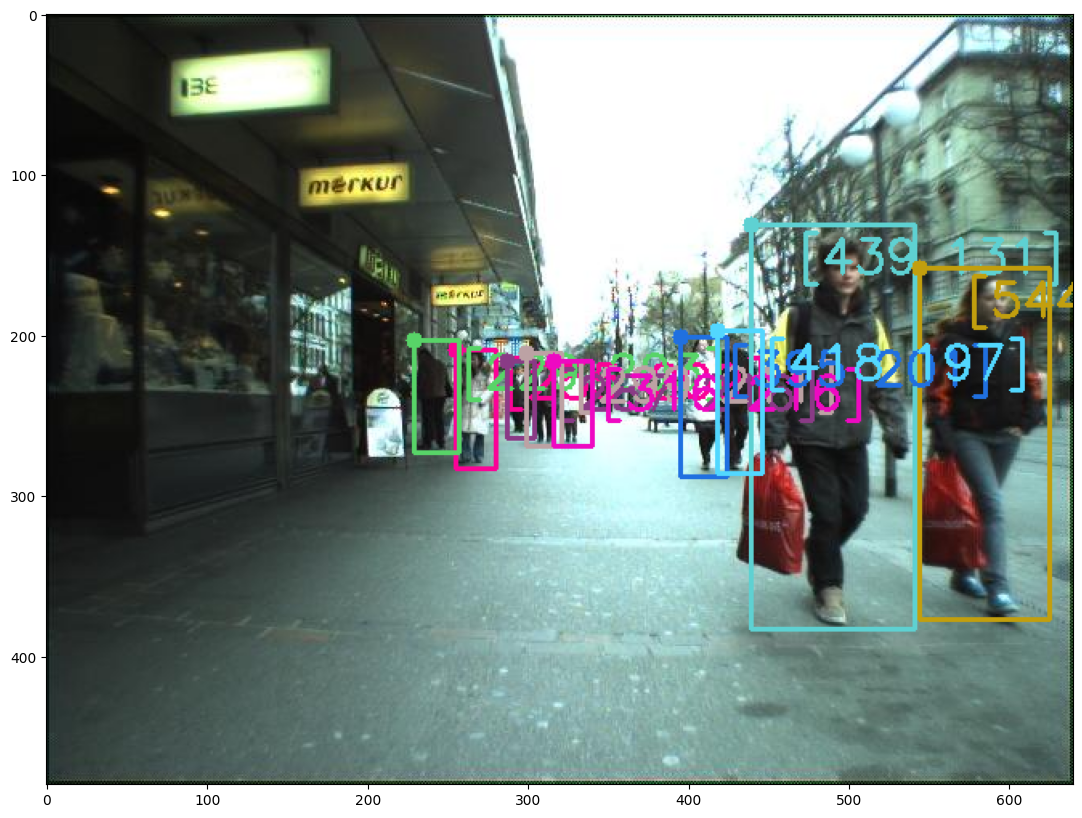

In [25]:
# get current frame
idx = 100
current_tracks = gt.loc[gt.frame == (idx + 1), :]
frame = cv2.cvtColor(cv2.imread(train_images[idx]), cv2.COLOR_BGR2RGB)

gt_bbox = []

# draw ground truth on frame
for id in current_tracks.id:
    track = current_tracks[current_tracks.id == id]

    color = get_color(id)

    pt1 = track.iloc[0, 2:4].to_numpy().astype(int)
    pt2 = pt1 + track.iloc[0, 4:6].to_numpy().round().astype(int)
    frame = cv2.rectangle(frame, pt1, pt2, color, 2)

    cv2.circle(frame, pt1, 5, color, -1)

    frame = cv2.putText(frame, str(pt1), (pt1 + 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, 
                        color, thickness=2)

    # print(pt1, pt2)
    gt_bbox.append([pt1[0], pt1[1], pt2[0], pt2[1]])


# convert to array
gt_bbox = np.array(gt_bbox)

# display frame
plt.imshow(frame)

Compare Ground Truth to Tracklets

In [26]:
gt_bbox

array([[255, 209, 280, 283],
       [439, 131, 541, 383],
       [544, 158, 625, 377],
       [229, 203, 257, 273],
       [287, 216, 304, 264],
       [299, 211, 321, 269],
       [316, 216, 340, 269],
       [395, 201, 424, 288],
       [418, 197, 446, 286]])

In [27]:
frame_tracks

array([[418, 198, 443, 286],
       [546, 160, 621, 377],
       [302, 218, 318, 267],
       [397, 200, 422, 285],
       [439, 139, 537, 382],
       [256, 206, 278, 278],
       [286, 220, 300, 262],
       [319, 220, 336, 268],
       [229, 206, 250, 271]])

Perform Hungarian Matching on tracks from tracker and Ground Truth

In [28]:
matches, false_positives, missed_tracks = \
            associate(gt_bbox, frame_tracks, thresh=1e-6)

In [29]:
matches

array([[0, 5],
       [1, 4],
       [2, 1],
       [3, 8],
       [4, 6],
       [5, 2],
       [6, 7],
       [7, 3],
       [8, 0]])

In [30]:
false_positives

[]

In [31]:
missed_tracks

[]

Save all tracks for future usage

In [32]:
frame_arr = np.arange(0, len(all_tracks))

In [33]:
all_tracks[0]

array([[        541,         216,         554,         248,           7,           0],
       [        211,         201,         226,         255,           6,           0],
       [        269,         210,         284,         246,           5,           0],
       [        587,         211,         602,         246,           4,           0],
       [        455,         208,         483,         274,           3,           0],
       [        224,         185,         256,         282,           2,           0],
       [        293,         150,         351,         321,           1,           0]])

In [34]:
all_tracks_2 = []

for i in range(len(all_tracks)):
    all_tracks_2.append(np.hstack((np.ones((len(all_tracks[i]), 1))*i, all_tracks[i])))

In [35]:
df = pd.DataFrame(np.vstack(all_tracks_2))
df.columns = ["frame", "x1", "y1", "x2", "y2", "id", "cat"]
df.head()

,frame,x1,y1,x2,y2,id,cat
0,0.0,541.0,216.0,554.0,248.0,7.0,0.0
1,0.0,211.0,201.0,226.0,255.0,6.0,0.0
2,0.0,269.0,210.0,284.0,246.0,5.0,0.0
3,0.0,587.0,211.0,602.0,246.0,4.0,0.0
4,0.0,455.0,208.0,483.0,274.0,3.0,0.0


In [36]:
train_images[0]

'MOT15/train/ETH-Bahnhof/img1/000001.jpg'

In [37]:
df.to_csv("ADL-Rundle-6_SORT_tracks.csv")

In [38]:
all_detections[0]

array([[     293.08,      150.64,      351.45,      321.15,           0,     0.90558],
       [      224.2,      185.92,      256.63,      282.38,           0,     0.84266],
       [     455.39,      208.81,         483,      274.61,           0,     0.75515],
       [     587.26,      211.74,       602.7,      246.68,           0,     0.50708],
       [     269.97,      210.44,      284.41,      246.73,           0,     0.32113],
       [     211.15,      201.71,      226.49,      255.99,           0,     0.27017],
       [     541.03,       216.7,      554.11,      248.63,           0,      0.2591]], dtype=float32)

In [39]:
all_detections_2 = []

for i in range(len(all_detections)):
    all_detections_2.append(np.hstack((np.ones((len(all_detections[i]), 1))*i, all_detections[i])))

In [40]:
df2 = pd.DataFrame(np.vstack(all_detections_2))
df2.columns = ["frame", "x1", "y1", "x2", "y2", "cat", "conf"]
df2.head()

,frame,x1,y1,x2,y2,cat,conf
0,0.0,293.078369,150.638916,351.447754,321.145355,0.0,0.905575
1,0.0,224.198669,185.917297,256.628448,282.383545,0.0,0.842656
2,0.0,455.390686,208.806763,483.000183,274.605286,0.0,0.755152
3,0.0,587.264526,211.743683,602.703003,246.684662,0.0,0.507081
4,0.0,269.969543,210.435547,284.406677,246.733276,0.0,0.321132


In [41]:
df2.to_csv("ADL-Rundle-6_YOLOv8_detections.csv")

Use the match and missed tracks arrays to assign tracklet and ground truth to each agent


Each Ground Truth Track has an ID the Trackers also have IDs. The IDs should never cross, if they do that is a mismatch error. The agents could possibly keep track of which ground truth IDs are associated (or just the previous ground truth ID. If the new ground truth ID is different, then there is a mismatch error. It's possible that the tracker was wrong the entire time, so we will only conisder mismatch errors between single frames. i.e. if there is a single track switch then we only count it as a single mismatch error.

